In [2]:
import numpy as np 
import pandas as pd 
from nltk.corpus import stopwords
import nltk
import string
from nltk import word_tokenize
import re
import gensim
import pyLDAvis.gensim
from nltk.corpus import wordnet
from wordcloud import WordCloud
from spacy import displacy
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
stop = stopwords.words('english')
from imp import reload


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:627: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Dep

/kaggle/input/cyberbullying-detection-dataset/twitter_parsed_dataset.csv


In [3]:
import spacy
nlp = spacy.load("en_core_web_sm")

## Load the dataset

In [4]:
df = pd.read_csv("/kaggle/input/cyberbullying-detection-dataset/twitter_parsed_dataset.csv")
df

,index,id,Text,Annotation,oh_label
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.75596338802373E+017,5.75596338802373E+017,#mkr No No No No No No,none,0.0
...,...,...,...,...,...
16846,5.75606766236475E+017,5.75606766236475E+017,"Feeling so sorry for the girls, they should be...",none,0.0
16847,5.72333822886326E+017,5.72333822886326E+017,#MKR 'pretty good dishes we're happy with' - O...,none,0.0
16848,5.72326950057845E+017,5.72326950057845E+017,RT @colonelkickhead: Deconstructed lemon tart!...,none,0.0
16849,5.74799612642357E+017,5.74799612642357E+017,@versacezaynx @nyazpolitics @greenlinerzjm You...,none,0.0


## Data Understannding

0.0    11501
1.0     5347
Name: oh_label, dtype: int64


<AxesSubplot:>

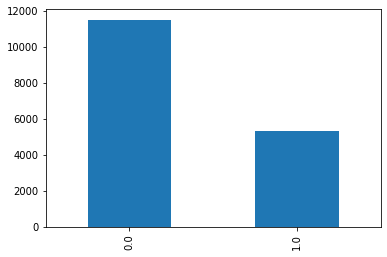

In [5]:
print(df['oh_label'].value_counts())
df['oh_label'].value_counts().plot(kind='bar')

- This is an imbalance class classification problem to classify wheather the tweet was bullying or not.

In [6]:
df.describe(include='O')

,index,id,Text,Annotation
count,16851,16850,16850,16848
unique,16851,16850,16850,3
top,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none
freq,1,1,1,11501


In [7]:
df.describe()

,oh_label
count,16848.000000
mean,0.317367
std,0.465465
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [8]:
df['Annotation'].value_counts()

none      11501
sexism     3377
racism     1970
Name: Annotation, dtype: int64

**Insights:**

- Bullying tweets are annotated as either sexism or racism
- Out of 5347 tweets we have 3377 tweets annoted as a sexism and 1970 tweets annoted as a racism

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16851 entries, 0 to 16850
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       16851 non-null  object 
 1   id          16850 non-null  object 
 2   Text        16850 non-null  object 
 3   Annotation  16848 non-null  object 
 4   oh_label    16848 non-null  float64
dtypes: float64(1), object(4)
memory usage: 658.4+ KB


- There are few rows having null values. we will drop them
- We can also drop index and id columns as they are not needed

In [10]:
# drop the unnecessary columns
ndf = df.drop(['index','id'], axis=1)
ndf.dropna(inplace=True)
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16848 entries, 0 to 16850
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Text        16848 non-null  object 
 1   Annotation  16848 non-null  object 
 2   oh_label    16848 non-null  float64
dtypes: float64(1), object(2)
memory usage: 526.5+ KB


In [11]:
ndf.oh_label.value_counts()

0.0    11501
1.0     5347
Name: oh_label, dtype: int64

In [12]:
# unprocessed dataframe to perform pre-processing and feature extraction to get final text corpus
ndf.head()

,Text,Annotation,oh_label
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,#mkr No No No No No No,none,0.0


## Text cleaning and feature extraction

In [13]:
# count the stopwords
ndf['stopwords'] = ndf['Text'].apply(lambda x: len([x for x in x.split() if x in stop]))
ndf[['Text','stopwords']].head()

,Text,stopwords
0,@halalflaws @biebervalue @greenlinerzjm I read...,4
1,@ShreyaBafna3 Now you idiots claim that people...,9
2,"RT @Mooseoftorment Call me sexist, but when I ...",7
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",4
4,#mkr No No No No No No,0


In [14]:
# count the puncutuation
def punct_count(text):
    count = sum([1 for char in text if char in string.punctuation])
    return count

ndf['Punc_count'] = ndf['Text'].apply(lambda x: punct_count(x))
ndf[['Text','Punc_count']].head()

,Text,Punc_count
0,@halalflaws @biebervalue @greenlinerzjm I read...,11
1,@ShreyaBafna3 Now you idiots claim that people...,3
2,"RT @Mooseoftorment Call me sexist, but when I ...",4
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",3
4,#mkr No No No No No No,1


In [15]:
# count the hashtags and mentions
ndf['hashtags/mentions'] = ndf['Text'].apply(lambda x: len([x for x in x.split() if x.startswith(('#','@'))]))
ndf[['Text','hashtags/mentions']].head()

,Text,hashtags/mentions
0,@halalflaws @biebervalue @greenlinerzjm I read...,3
1,@ShreyaBafna3 Now you idiots claim that people...,1
2,"RT @Mooseoftorment Call me sexist, but when I ...",1
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1
4,#mkr No No No No No No,1


In [16]:
ndf['hashtags/mentions'].loc[ndf['hashtags/mentions'] != 0].count()

15328

- Out of 16848 documents, 15328 has either hashtag or mention


In [17]:
# find the number of numerics
ndf['numerics'] = ndf['Text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
ndf[['Text','numerics']].head()

,Text,numerics
0,@halalflaws @biebervalue @greenlinerzjm I read...,0
1,@ShreyaBafna3 Now you idiots claim that people...,0
2,"RT @Mooseoftorment Call me sexist, but when I ...",0
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",0
4,#mkr No No No No No No,0


In [18]:
# number of documents with digit char
ndf[ndf['numerics'] != 0][['Text','numerics']].shape

(883, 2)

### Text cleaning function

In [19]:
# Now let's clean the text data for further analysis
only_english = set(nltk.corpus.words.words())
def text_cleaning(text):
    """ A function to clean the text data"""
    
    sample = text
    sample = " ".join([x.lower() for x in sample.split()])
    sample = re.sub(r"\S*https?:\S*", '', sample) # links and urls
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('[%s]' % re.escape(string.punctuation), '', sample) #punctuations
    sample = re.sub('\w*\d\w', '', sample) #digits with trailing or preceeding text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    sample = re.sub(r', /<[^>]+>/', '', sample)    #HTML attributes
    
    sample = ' '.join([w for w in nltk.wordpunct_tokenize(sample) if w.lower() in only_english or not w.isalpha()]) #doesn't remove indian languages
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    sample = sample.strip()
    sample = " ".join([x.strip() for x in sample.split()])
    
    return sample

<>:9: DeprecationWarning: invalid escape sequence \[
<>:10: DeprecationWarning: invalid escape sequence \(
<>:12: DeprecationWarning: invalid escape sequence \w
<>:19: DeprecationWarning: invalid escape sequence \s
<>:9: DeprecationWarning: invalid escape sequence \[
<>:10: DeprecationWarning: invalid escape sequence \(
<>:12: DeprecationWarning: invalid escape sequence \w
<>:19: DeprecationWarning: invalid escape sequence \s
<>:9: DeprecationWarning: invalid escape sequence \[
<>:10: DeprecationWarning: invalid escape sequence \(
<>:12: DeprecationWarning: invalid escape sequence \w
<>:19: DeprecationWarning: invalid escape sequence \s
/tmp/ipykernel_27/2222851142.py:9: DeprecationWarning: invalid escape sequence \[
  sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
/tmp/ipykernel_27/2222851142.py:10: DeprecationWarning: invalid escape sequence \(
  sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
/tmp/ipykernel_27/2222851142.py:12: DeprecationW

In [20]:
# call the clean function to clean the the data
ndf['cleaned_text'] = ndf['Text'].apply(lambda x: text_cleaning(x))
ndf[['Text','cleaned_text']]

,Text,cleaned_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,i read them in change in meaning the history o...
1,@ShreyaBafna3 Now you idiots claim that people...,shreyabafna3 now you claim that people who tri...
2,"RT @Mooseoftorment Call me sexist, but when I ...",call me but when i go to an auto place id rath...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",wrong the example of and the exactly
4,#mkr No No No No No No,no no no no no no
...,...,...
16846,"Feeling so sorry for the girls, they should be...",feeling so sorry for the they should be safe a...
16847,#MKR 'pretty good dishes we're happy with' - O...,pretty good were happy with well never eating ...
16848,RT @colonelkickhead: Deconstructed lemon tart!...,lemon we please go just one season of without ...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,you are too stupid to talk to blocked


**Next steps:**

- Stemming, lemmat, stop-word removal, pos tagging
- Topic modeling and NER by annotation
- Clean text feature extraction 
- EDA

In [21]:
# stop word removal function
stopwrds = set(stopwords.words('english'))
def remove_stowords(text, cores=2):
    
    sample = text
    sample = sample.lower()
    sample = [word for word in sample.split() if not word in stopwrds]
    sample = ' '.join(sample)
    
    return sample


# get POS Tag for word
def get_wordnet_pos(word):
    
    treebank_tag = nltk.pos_tag([word])[0][1]
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

# lemmatization function
lemmatizer = WordNetLemmatizer()
def lemma_clean_text(text, cores = 1):
 
    sample = text
    sample = sample.split()
    sample = [lemmatizer.lemmatize(word.lower()) for word in sample]
    sample = ' '.join(sample)
    
    return sample

# stemming of the text data
ps = PorterStemmer()
def stem_clean_text(text):
 
    sample = text
    sample = sample.split()
    sample = [ps.stem(word) for word in sample]
    sample = ' '.join(sample)
    
    return sample

# correct the spelling
def correct_spelling(text):
    
    sample = text
    sample = str(TextBlob(text).correct())
    
    return sample

### POS tagging 

- Parts of speech taggin or POS used to tag or identify components of speech that are used in certain sentense.
- We will use nltk's pos_tagging function for pos identification

In [22]:
def sentense_pos_tagger(text):
    
    # tokenize the text
    sample = word_tokenize(text)
    tags = nltk.pos_tag(sample)
        
    return tags

sentense_pos_tagger(ndf['cleaned_text'][0])

[('i', 'NN'),
 ('read', 'VBP'),
 ('them', 'PRP'),
 ('in', 'IN'),
 ('change', 'NN'),
 ('in', 'IN'),
 ('meaning', 'VBG'),
 ('the', 'DT'),
 ('history', 'NN'),
 ('of', 'IN'),
 ('slavery', 'NN')]

### NER 

- Named entity recognition helps to identify various entities present in text corpus such as Places, Persons, locations, date, language, etc.
- It is information extraction method to extract information in certain text
- We wiil spacy library's `en_core_web_sm` model to identify NER

In [23]:
# identify the text object
doc = nlp(",".join([te for te in ndf['cleaned_text'][0:100]]))

[(x.text,x.label_) for x in doc.ents]

[('five', 'CARDINAL'),
 ('one', 'CARDINAL'),
 ('today', 'DATE'),
 ('sassy', 'ORG'),
 ('million', 'CARDINAL'),
 ('two', 'CARDINAL'),
 ('last year', 'DATE'),
 ('first', 'ORDINAL'),
 ('mike brown such', 'PERSON'),
 ('morning', 'TIME')]

In [24]:
# display the
displacy.render(doc, style='ent')

### Topic modelling

> **Topic modeling is the process of using unsupervised learning techniques to extract the main topics that occur in a collection of documents.**

In [25]:
# define pre-processing function to model topics based on annotation
def preprocess_topic(df, topic):
    """ Preprocessing function to model text data based on give topics.
    
    args:
    df = input dataframe
    topic = input topic "nonn", "sexism", or "racism"
    
    returns:
    corpus of words under given topic
    """
    corpus=[]
    # topic wise division
    if topic == 'none':
        for doc in ndf[ndf['Annotation'] == 'none']['cleaned_text']:
            stop_word_removal = remove_stowords(doc)
            lemmmatized_sample = lemma_clean_text(stop_word_removal)
            words = lemmmatized_sample.split()
            corpus.append(words)
            
    elif topic == 'sexism':
        for doc in ndf[ndf['Annotation'] == 'sexism']['cleaned_text']:
            stop_word_removal = remove_stowords(doc)
            lemmmatized_sample = lemma_clean_text(stop_word_removal)
            words = lemmmatized_sample.split()
            corpus.append(words)
                
    elif topic == 'racism':
        for doc in ndf[ndf['Annotation'] == 'racism']['cleaned_text']:
            stop_word_removal = remove_stowords(doc)
            lemmmatized_sample = lemma_clean_text(stop_word_removal)
            words = lemmmatized_sample.split()
            corpus.append(words) 
            
    return corpus  

In [26]:
# corpus of the words
corpus = preprocess_topic(ndf, 'racism')

# creat BOW model from corpus
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

# create LDA model using gensim library
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                   num_topics = 4,
                                   id2word = dic,
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.022*"religion" + 0.012*"nothing" + 0.012*"slavery" + 0.011*"salon" + 0.011*"dont" + 0.010*"every" + 0.010*"prophet" + 0.009*"slave" + 0.009*"million" + 0.008*"also"'),
 (1,
  '0.017*"prophet" + 0.016*"like" + 0.013*"hatred" + 0.013*"world" + 0.011*"religion" + 0.011*"dont" + 0.009*"hate" + 0.009*"yes" + 0.009*"murder" + 0.008*"get"'),
 (2,
  '0.026*"war" + 0.019*"humanity" + 0.017*"declared" + 0.014*"ago" + 0.011*"stupid" + 0.010*"terrorist" + 0.010*"like" + 0.008*"time" + 0.008*"one" + 0.006*"would"'),
 (3,
  '0.029*"people" + 0.015*"murder" + 0.013*"religion" + 0.012*"want" + 0.012*"one" + 0.011*"like" + 0.008*"prophet" + 0.008*"freedom" + 0.007*"murdering" + 0.007*"ironmanl1"')]

In [27]:
# visualizing the topics
def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

plot_lda_vis(lda_model, bow_corpus, dic)

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.019402  0.055788       1        1  28.853995
3      0.038396  0.102357       2        1  27.044965
2     -0.150579 -0.039696       3        1  22.810222
0      0.092781 -0.118450       4        1  21.290818, topic_info=         Term        Freq       Total Category  logprob  loglift
32     people  100.000000  100.000000  Default  30.0000  30.0000
311       war   75.000000   75.000000  Default  29.0000  29.0000
168  humanity   48.000000   48.000000  Default  28.0000  28.0000
409  declared   40.000000   40.000000  Default  27.0000  27.0000
408       ago   36.000000   36.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
65      alima    9.889073   31.200550   Topic4  -5.4138   0.3979
150     still    8.917568   24.586698   Topic4  -5.5172   0.5327
152      know    9.648929   37.752315   Topic4  -5.4384   0.1827
47      world   10.488190   62.452979   Topic4  -5.3550  -0.2373
155   qoloob4    8.925662   27.069564   Topic4  -5.5163   0.4374

[276 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1278      2  0.913764   aberration
1252      1  0.945754  abunaseeha2
641       1  0.121918          age
641       2  0.731508          age
641       4  0.121918          age
...     ...       ...          ...
214       4  0.032867          yes
1423      1  0.810738        young
1176      3  0.908222        youve
165       3  0.277612         zero
165       4  0.666268         zero

[445 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

## Correct the text for modeling purpose

In [28]:
# funtion to correct text using lammatization and spell correct techniques
stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

def correct_text(text, stem=False, lemma=False, spell=False):
    if lemma and stem:
        raise Exception('Either stem or lemma can be true, not both!')
        return text
    
    sample = text
    
    #removing stopwords
    sample = sample.lower()
    sample = [word for word in sample.split() if word not in stops]
    sample = ' '.join(sample)
    
    if lemma == True:
        new_sample = []
        sample = sample.split()
        word_tags = [get_wordnet_pos(word.lower()) for word in sample]
        for word in sample:
            word_tag = word_tags[sample.index(word)]
            if word_tag == "":
                new_sample.append(lemmatizer.lemmatize(word))
            else:
                new_sample.append(lemmatizer.lemmatize(word.lower(), word_tag))
        sample = ' '.join(new_sample)
        
    if stem == True:
        sample = sample.split()
        sample = [ps.stem(word) for word in sample]
        sample = ' '.join(sample)
    
    if spell == True:
        sample = str(TextBlob(text).correct())
    
    return sample

In [29]:
ndf['correct_text'] = ndf['cleaned_text'].apply(lambda x: correct_text(x))
ndf.head()

,Text,Annotation,oh_label,stopwords,Punc_count,hashtags/mentions,numerics,cleaned_text,correct_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,4,11,3,0,i read them in change in meaning the history o...,read change meaning history slavery
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,9,3,1,0,shreyabafna3 now you claim that people who tri...,shreyabafna3 claim people tried stop becoming ...
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,7,4,1,0,call me but when i go to an auto place id rath...,call go auto place id rather talk guy
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,4,3,1,0,wrong the example of and the exactly,wrong example exactly
4,#mkr No No No No No No,none,0.0,0,1,1,0,no no no no no no,


## Text data visualization